* 6000, 6002, 1171 (국내), 1871 (해외)

## Import

In [93]:
import copy
import numpy as np
from pypfopt import risk_models, exceptions
from pypfopt import EfficientFrontier, CLA
from copy import deepcopy
import scipy.cluster.hierarchy as sch
import warnings

import matplotlib.pyplot as plt

plt.style.use("seaborn-deep")

In [94]:
from pypfopt.expected_returns import mean_historical_return, ema_historical_return, capm_return, returns_from_prices
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import pypfopt
import pandas as pd
import numpy as np
import datetime
import os

plt.rcParams['font.family']= "gulim"

* functions

In [95]:
def check(m, S):
    return EfficientFrontier(m, S)

def _plot_io(**kwargs):
    """
    Helper method to optionally save the figure to file.
    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param dpi: dpi of figure to save or plot, defaults to 300
    :type dpi: int (between 50-500)
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    """
    filename = kwargs.get("filename", None)
    showfig = kwargs.get("showfig", False)
    dpi = kwargs.get("dpi", 300)

    plt.tight_layout()
    if filename:
        plt.savefig(fname=filename, dpi=dpi)
    if showfig:  # pragma: no cover
        plt.show()


def plot_covariance(cov_matrix, plot_correlation=False, show_tickers=True, **kwargs):
    """
    Generate a basic plot of the covariance (or correlation) matrix, given a
    covariance matrix.
    :param cov_matrix: covariance matrix
    :type cov_matrix: pd.DataFrame or np.ndarray
    :param plot_correlation: whether to plot the correlation matrix instead, defaults to False.
    :type plot_correlation: bool, optional
    :param show_tickers: whether to use tickers as labels (not recommended for large portfolios),
                        defaults to True
    :type show_tickers: bool, optional
    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    if plot_correlation:
        matrix = risk_models.cov_to_corr(cov_matrix)
    else:
        matrix = cov_matrix
    fig, ax = plt.subplots()

    cax = ax.imshow(matrix)
    fig.colorbar(cax)

    if show_tickers:
        ax.set_xticks(np.arange(0, matrix.shape[0], 1))
        ax.set_xticklabels(matrix.index)
        ax.set_yticks(np.arange(0, matrix.shape[0], 1))
        ax.set_yticklabels(matrix.index)
        plt.xticks(rotation=90)

    _plot_io(**kwargs)

    return ax


def plot_dendrogram(hrp, ax=None, show_tickers=True, **kwargs):
    """
    Plot the clusters in the form of a dendrogram.
    :param hrp: HRPpt object that has already been optimized.
    :type hrp: object
    :param show_tickers: whether to use tickers as labels (not recommended for large portfolios),
                        defaults to True
    :type show_tickers: bool, optional
    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    ax = ax or plt.gca()

    if hrp.clusters is None:
        warnings.warn(
            "hrp param has not been optimized.  Attempting optimization.",
            RuntimeWarning,
        )
        hrp.optimize()

    if show_tickers:
        sch.dendrogram(hrp.clusters, labels=hrp.tickers, ax=ax, orientation="top")
        ax.tick_params(axis="x", rotation=90)
        plt.tight_layout()
    else:
        sch.dendrogram(hrp.clusters, no_labels=True, ax=ax)

    _plot_io(**kwargs)

    return ax


def _plot_cla(cla, points, ax, show_assets, show_tickers):
    """
    Helper function to plot the efficient frontier from a CLA object
    """
    if cla.weights is None:
        cla.max_sharpe()
    optimal_ret, optimal_risk, _ = cla.portfolio_performance()

    if cla.frontier_values is None:
        cla.efficient_frontier(points=points)

    mus, sigmas, _ = cla.frontier_values

    ax.plot(sigmas, mus, label="Efficient frontier")
    ax.scatter(optimal_risk, optimal_ret, marker="x", s=100, color="r", label="optimal")

    asset_mu = cla.expected_returns
    asset_sigma = np.sqrt(np.diag(cla.cov_matrix))
    if show_assets:
        ax.scatter(
            asset_sigma,
            asset_mu,
            s=30,
            color="k",
            label="assets",
        )
        if show_tickers:
            for i, label in enumerate(cla.tickers):
                ax.annotate(label, (asset_sigma[i], asset_mu[i]))
    return ax


def _ef_default_returns_range(ef, points):
    """
    Helper function to generate a range of returns from the GMV returns to
    the maximum (constrained) returns
    """
    ef_minvol = check(mean_return, S_exp)
    ef_maxret = check(mean_return, S_exp)
    #ef_minvol = copy.deepcopy(ef)
    #ef_maxret = copy.deepcopy(ef)

    ef_minvol.min_volatility()
    min_ret = ef_minvol.portfolio_performance()[0]
    max_ret = ef_maxret._max_return()
    return np.linspace(min_ret, max_ret - 0.0001, points)


def _plot_ef(ef, ef_param, ef_param_range, ax, show_assets, show_tickers):
    """
    Helper function to plot the efficient frontier from an EfficientFrontier object
    """
    mus, sigmas = [], []

    # Create a portfolio for each value of ef_param_range
    for param_value in ef_param_range:
        try:
            if ef_param == "utility":
                ef.max_quadratic_utility(param_value)
            elif ef_param == "risk":
                ef.efficient_risk(param_value)
            elif ef_param == "return":
                ef.efficient_return(param_value)
            else:
                raise NotImplementedError(
                    "ef_param should be one of {'utility', 'risk', 'return'}"
                )
        except exceptions.OptimizationError:
            continue
        except ValueError:
            warnings.warn(
                "Could not construct portfolio for parameter value {:.3f}".format(
                    param_value
                )
            )

        ret, sigma, _ = ef.portfolio_performance()
        mus.append(ret)
        sigmas.append(sigma)

    ax.plot(sigmas, mus, label="Efficient frontier")

    asset_mu = ef.expected_returns
    asset_sigma = np.sqrt(np.diag(ef.cov_matrix))
    if show_assets:
        ax.scatter(
            asset_sigma,
            asset_mu,
            s=30,
            color="k",
            label="assets",
        )
        if show_tickers:
            for i, label in enumerate(ef.tickers):
                ax.annotate(label, (asset_sigma[i], asset_mu[i]))
    return ax


def plot_efficient_frontier(
    opt,
    ef_param="return",
    ef_param_range=None,
    points=100,
    ax=None,
    show_assets=True,
    show_tickers=False,
    **kwargs
):
    """
    Plot the efficient frontier based on either a CLA or EfficientFrontier object.
    :param opt: an instantiated optimizer object BEFORE optimising an objective
    :type opt: EfficientFrontier or CLA
    :param ef_param: [EfficientFrontier] whether to use a range over utility, risk, or return.
                     Defaults to "return".
    :type ef_param: str, one of {"utility", "risk", "return"}.
    :param ef_param_range: the range of parameter values for ef_param.
                           If None, automatically compute a range from min->max return.
    :type ef_param_range: np.array or list (recommended to use np.arange or np.linspace)
    :param points: number of points to plot, defaults to 100. This is overridden if
                   an `ef_param_range` is provided explicitly.
    :type points: int, optional
    :param show_assets: whether we should plot the asset risks/returns also, defaults to True
    :type show_assets: bool, optional
    :param show_tickers: whether we should annotate each asset with its ticker, defaults to False
    :type show_tickers: bool, optional
    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    ax = ax or plt.gca()

    if isinstance(opt, CLA):
        ax = _plot_cla(
            opt, points, ax=ax, show_assets=show_assets, show_tickers=show_tickers
        )
    elif isinstance(opt, EfficientFrontier):
        if ef_param_range is None:
            ef_param_range = _ef_default_returns_range(opt, points)

        ax = _plot_ef(
            opt,
            ef_param,
            ef_param_range,
            ax=ax,
            show_assets=show_assets,
            show_tickers=show_tickers,
        )
    else:
        raise NotImplementedError("Please pass EfficientFrontier or CLA object")

    ax.legend()
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")

    _plot_io(**kwargs)
    return ax


def plot_weights(weights, ax=None, **kwargs):
    """
    Plot the portfolio weights as a horizontal bar chart
    :param weights: the weights outputted by any PyPortfolioOpt optimizer
    :type weights: {ticker: weight} dict
    :param ax: ax to plot to, optional
    :type ax: matplotlib.axes
    :return: matplotlib axis
    :rtype: matplotlib.axes
    """
    ax = ax or plt.gca()

    desc = sorted(weights.items(), key=lambda x: x[1], reverse=True)
    labels = [i[0] for i in desc]
    vals = [i[1] for i in desc]

    y_pos = np.arange(len(labels))

    ax.barh(y_pos, vals)
    ax.set_xlabel("Weight")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()

    _plot_io(**kwargs)
    return ax

In [96]:
def read_xlsx(name):
    instance = xw.App(visible = False)
    xlsx_data = xw.Book(name).sheets[0]
    df = xlsx_data.range('A1').options(pd.DataFrame, index = False, expand = 'table').value
    instance.quit()
    instance.kill()
    return df

def read_data(name):
    try :
        output = pd.read_excel(name)
    except ValueError:    
        output = read_xlsx(name)
    return output

## Load data

In [97]:
data_path = os.getcwd() + "\\datasets\\"

In [98]:
stock_df = read_data(data_path + "stock_df.xlsx")

In [99]:
port_input = stock_df.iloc[:, 1:]

In [8]:
total_df = read_data(data_path + "total_df.xlsx")

In [157]:
# 환율 가져오기
if os.path.isfile(data_path + "currency.xlsx"):
    currency = read_data(data_path + "currency.xlsx")

start_date = np.max(currency.Date)

try :
    append_curr = fdr.DataReader("USD/KRW", start = start_date)
    append_curr = append_curr.reset_index()

    currency = currency.loc[currency.Date < start_date, :]
    currency = pd.concat([currency, append_curr])
    currency.index = [x for x in range(currency.shape[0])]
    currency.to_excel(data_path + "currency.xlsx", index = False)
    
except:
    print("추가행 없음")
    pass

In [179]:
start_date = '2020-05-23'
start_date = pd.to_datetime(start_date, utc = True)

snp_500 = fdr.DataReader('US500', start_date)['Close']
kospi = fdr.DataReader('KS11', start_date)['Close']

snp_500.index = pd.to_datetime(snp_500.index, utc = True)
kospi.index = pd.to_datetime(kospi.index, utc = True)

currency.Date = pd.to_datetime(currency.Date, utc = True)

exchange = currency.loc[currency.Date.isin(snp_500.index)]['Close']
exchange.index = snp_500.index

snp_500 *= exchange

In [154]:
'''
bench_snp = snp_500.loc[snp_500.index.isin(pf_returns.index)]
bench_kospi = kospi.loc[kospi.index.isin(pf_returns.index)]
'''

* Return 계산하기

In [100]:
def get_return(port_input, opt = 'mean'):
    if opt == 'mean':
        output = mean_historical_return(port_input)
    elif opt == 'ema':
        output = ema_historical_return(port_input)
    elif opt == 'capm':
        output = capm_return(port_input)
    elif opt == "price":
        output = returns_from_prices(port_input)
    return output

In [101]:
mean_return = get_return(port_input, 'mean')
ema_return = get_return(port_input, 'ema')
capm_return = get_return(port_input, 'capm')
price_return = get_return(port_input, 'price')

* Risk 계산하기

In [102]:
def get_cov(port_input, opt = 'CovarianceShrinkage-01'):
    if opt == 'CovarianceShrinkage-01':
        S = CovarianceShrinkage(port_input).ledoit_wolf()
    elif opt == 'CovarianceShrinkage-02':
        S = CovarianceShrinkage(port_input).shrunk_covariance()
    elif opt == 'CovarianceShrinkage-03':
        S = CovarianceShrinkage(port_input).oracle_approximating()
    elif opt == "exp_cov":
        S = pypfopt.risk_models.exp_cov(port_input)
    elif opt == "semicovariance":
        S = pypfopt.risk_models.semicovariance(port_input)
    return S

In [103]:
cs_01 = get_cov(port_input, opt = 'CovarianceShrinkage-01')
cs_02 = get_cov(port_input, opt = 'CovarianceShrinkage-02')
cs_03 = get_cov(port_input, opt = 'CovarianceShrinkage-03')
S_exp = get_cov(port_input, opt = 'exp_cov')
S_semi = get_cov(port_input, opt = 'semicovariance')

* etf list 정리

In [104]:
etf_df = fdr.StockListing("ETF/KR")
etf_list =[x for x in port_input.columns if x in list(etf_df.Name)]

cate = ["etf" if x in etf_list else "stock" for x in port_input.columns]
sector_dict = {x:y for x,y in zip(port_input.columns, cate)}

get_lower = (0, 0)
get_upper = (0.8, 0.8)

lower_dict = {"etf" : get_lower[0], "stock" : get_lower[1]}
upper_dict = {"etf" : get_upper[0], "stock" : get_upper[1]}

* EfficientFrontier

In [105]:
def mvo(ef, method = "max_sharpe"):
    if method == 'max_sharpe':
        weights = ef.max_sharpe()
    elif method == "min_volatility":
        weights = ef.min_volatility()
    elif method == "max_quadratic_utility":
        weights = ef.max_quadratic_utility()
    return weights

In [106]:
ef = EfficientFrontier(mean_return, S_semi)
ef.add_sector_constraints(sector_dict, sector_lower=lower_dict, sector_upper=upper_dict)
#ef.add_objective(pypfopt.objective_functions.L2_reg, gamma=2)
weights = mvo(ef, 'max_sharpe')

In [107]:
ef = EfficientFrontier(mean_return, S_semi)
weights = mvo(ef, 'min_volatility')

In [108]:
ef = EfficientFrontier(mean_return, S_semi)
weights = mvo(ef, 'max_quadratic_utility')

In [ ]:
# maximises return for a given target risk
ef.efficient_risk(0.08)

# minimises risk for a given target return
ef.efficient_return(0.01)

In [109]:
# (expected return, volatility, sharpe ratio) for the optimized portfolio
ef.portfolio_performance()

(0.2574044200480587, 0.19508384666080605, 1.2169353030076129)

* risk parity optimization

In [220]:
rp = pypfopt.hierarchical_portfolio.HRPOpt(price_return, S_semi)

In [223]:
rp.optimize()

OrderedDict([('AMD', 0.01367680552642929),
             ('JW중외제약', 0.025890068959592012),
             ('KODEX 미국S&P500TR', 0.21323336378241783),
             ('KODEX 코스피TR', 0.1563560599401391),
             ('LG전자', 0.04099825779722364),
             ('NAVER', 0.029190559128935156),
             ('OCI', 0.02228706665997298),
             ('SK바이오사이언스', 0.014044596197573764),
             ('SK하이닉스', 0.016537343315960615),
             ('STX', 0.022388476141968938),
             ('고려신용정보', 0.057002205921041514),
             ('메타 플랫폼스(페이스북)', 0.04916573680352075),
             ('삼성전자', 0.032645326154425565),
             ('삼천리자전거', 0.020240420988156965),
             ('씨티케이', 0.04380243500970432),
             ('아프리카TV', 0.03378837592754709),
             ('알파벳 A주', 0.06317489870156899),
             ('애플', 0.022222588958519713),
             ('엔비디아', 0.013559320493879298),
             ('카카오', 0.020635489457276973),
             ('카카오페이', 0.016411474304476672),
             ('퀄컴', 0.03

In [112]:
rp.portfolio_performance()

(0.13545626991592824, 0.1499549377461645, 0.7699397675811535)

* general efficient frontier

In [224]:
from pypfopt import expected_returns, EfficientSemivariance

In [225]:
mu = mean_historical_return(port_input)
historical_returns = returns_from_prices(port_input)
es = EfficientSemivariance(mu, historical_returns)

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:153: UserWarning: Removing NaNs from returns
  warnings.warn(


In [233]:
weights = es.clean_weights()
print(weights)
es.portfolio_performance(verbose=True)

AttributeError: Weights not yet computed

In [236]:
from pypfopt.cla import CLA

cla = CLA(mean_return, cs_01, weight_bounds=(0, 1))
cla.max_sharpe()

OrderedDict([('JW중외제약', 0.0),
             ('KODEX 미국S&P500TR', 0.26421232474320266),
             ('KODEX 코스피TR', 0.0),
             ('LG전자', 0.03585866158890932),
             ('NAVER', 0.0),
             ('OCI', 0.10706688035347246),
             ('SK바이오사이언스', 0.0),
             ('SK하이닉스', 0.0),
             ('STX', 0.0),
             ('고려신용정보', 0.24388873788412552),
             ('삼성전자', -1.658369860726531e-17),
             ('삼천리자전거', 0.0),
             ('씨티케이', 0.0),
             ('아프리카TV', 0.0),
             ('카카오', 0.0),
             ('카카오페이', 0.0),
             ('피씨엘', 0.0),
             ('한탑', 0.008707890932128634),
             ('애플', 0.26123142589774545),
             ('알파벳 A주', 0.03963725171271733),
             ('메타 플랫폼스(페이스북)', 0.0),
             ('엔비디아', 0.0),
             ('퀄컴', 0.03939682688769858),
             ('AMD', 0.0)])

* plotting

<AxesSubplot:xlabel='Weight'>

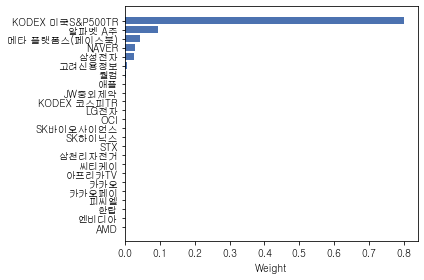

In [32]:
plot_weights(weights)

* back testing

In [ ]:
# weights를 기반으로 transactions이 구해지고
# transaction을 기반으로 postion이 구해지고
# position을 기반을 total return이 구해진다.

* pyfolio

In [113]:
from quantrocket.zipline import ZiplineBacktestResult

import pyfolio as pf
import matplotlib.pyplot as plt
import empyrical

* functions

In [114]:
def get_price(df, date, name):
    while True :
        if np.isnan(df.loc[df.Date == date, name].values[0]):
            date -= pd.Timedelta(days = 1)
            
            while True:
                if date not in list(df.Date):
                    date -= pd.Timedelta(days = 1)
                else:
                    break
        else:
            break
    return df.loc[df.Date == date, name].values[0]

## change에 따른 자산 변화
def cal_changes(initial_value, df, col):
    change_values = [initial_value]
    
    cnt = 0
    for pct in df.loc[:, col]:
        if np.isnan(pct):
            pct = 0
        change_values.append(change_values[cnt] + change_values[cnt] * pct)
        cnt += 1
    return change_values

In [115]:
bt = ZiplineBacktestResult.from_csv('https://raw.githubusercontent.com/quantrocket-codeload/quant-finance-lectures/master/quant_finance_lectures/Lecture33-Backtest-Results.csv')

In [116]:
benchmark_rets = bt.benchmark_returns
bt_returns = bt.perf['returns']
bt_positions = bt.positions
bt_transactions = bt.transactions

In [30]:
# 해당 금액으로 초기 포지션 진입 (금액 / 주가 = 수량)
# 수량 * 일자별 주가의 총 합으로 일자별 총 자산 변동 구하기
# 일자별 총 자산을 통해서 total_returns 구하기

In [117]:
bt_returns.head()

date
2013-01-02 00:00:00+00:00    0.001793
2013-01-03 00:00:00+00:00   -0.003708
2013-01-04 00:00:00+00:00   -0.001469
2013-01-07 00:00:00+00:00    0.000963
2013-01-08 00:00:00+00:00    0.006013
Name: returns, dtype: float64

In [118]:
# index: date
# columns : equities 별 투자 금액 (매수시 + 매도시 -) & cash
bt_positions.head()

column,Equity(QI000000004076 [AABA]),Equity(FIBBG005P7Q881 [AAL]),Equity(FIBBG005P7PXG8 [AALCP]),Equity(FIBBG003PNL136 [AAMC]),Equity(FIBBG000BHJWG1 [AAXN]),Equity(FIBBG0025Y4RY4 [ABBV]),Equity(FIBBG000BN5VZ4 [ABEV]),Equity(FIBBG000C101X4 [ABMD]),Equity(FIBBG000B9ZXB4 [ABT]),Equity(FIBBG000BHG9K0 [ACAD]),...,Equity(FIBBG000FWCC57 [ZIOP]),Equity(FIBBG000BLQVZ5 [ZLC]),Equity(FIBBG001J2P4Y9 [ZLTQ]),Equity(FIBBG000VD6768 [ZNGA]),Equity(FIBBG000BGFWQ6 [ZOLT]),Equity(FIBBG000FTMSF7 [ZQK]),Equity(FIBBG000F9CW36 [ZSL]),Equity(FIBBG0039320N9 [ZTS]),Equity(FIBBG001Z7M393 [ZU]),cash
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,4905.74,...,0.0,0.0,0.0,-4915.38,0.0,0.0,0.0,0.0,0.0,995809.100
2013-01-03 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4964.96,0.0,0.0,-5057.04,4947.58,...,0.0,0.0,0.0,-5019.08,0.0,0.0,-5246.8,0.0,0.0,995584.362
2013-01-04 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4917.77,0.0,0.0,-5028.16,5182.93,...,0.0,0.0,0.0,-5454.62,0.0,0.0,0.0,0.0,0.0,994047.331
2013-01-07 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4929.21,0.0,0.0,-5066.16,5083.56,...,0.0,0.0,0.0,-5433.88,0.0,0.0,0.0,0.0,0.0,992448.999
2013-01-08 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4821.96,0.0,0.0,-5069.20,5146.32,...,0.0,0.0,0.0,-5174.63,0.0,0.0,0.0,0.0,0.0,992003.832


In [119]:
# index : date
# amount : 구매 수량
# order_id : 난수
# price : 주당 주가
# sid, symbol : equity name
# txn_dallars : equities 별 투자 금액 (매수 시 음수, 매도 시 양수)
bt_transactions.head()

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.250,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.50
2013-01-02 15:31:00+00:00,166,edba92dff732476d9e3aba9e35eb303a,29.820,Equity(FIBBG000D32LR0 [ELLI]),Equity(FIBBG000D32LR0 [ELLI]),-4950.12
2013-01-02 15:31:00+00:00,686,93eb9f2de1d943c18409410ebecaf12e,7.260,Equity(FIBBG000BLCBN7 [HOV]),Equity(FIBBG000BLCBN7 [HOV]),-4980.36
2013-01-02 15:31:00+00:00,602,42cf80c523944a32a07c710171b90586,8.320,Equity(FIBBG000BJJGT8 [CLSN]),Equity(FIBBG000BJJGT8 [CLSN]),-5008.64
2013-01-02 15:31:00+00:00,550,fd972a3386374c03a25ab8d3821d9c03,9.089,Equity(FIBBG000BKXBV7 [ARNA]),Equity(FIBBG000BKXBV7 [ARNA]),-4998.95


In [ ]:
'''
temp_input = total_df.iloc[:, 1:]

mean_return = get_return(temp_input, 'mean')
cs_01 = get_cov(temp_input, opt = 'CovarianceShrinkage-01')

ef = EfficientFrontier(mean_return, cs_01)
weights = mvo(ef, 'max_sharpe')
'''

In [120]:
initial_amount = 1000000
total_amount = initial_amount

rebalancing_days = {"1M":30, "1Q": 90, "2Q": 180, "3Q": 270, "1Y":365, "2Y":730}
DAYS = "1M"

start_date = '2020-05-23'
start_date = pd.to_datetime(start_date, utc = True)
end_date = start_date + pd.Timedelta(days = rebalancing_days[DAYS])
re_date = start_date
utc_time = [pd.to_datetime(x,utc = True) for x in stock_df.Date]
stock_df.Date = utc_time

'''
get_lower = (0, 0)
get_upper = (1, 1)

lower_dict = {"etf" : get_lower[0], "stock" : get_lower[1]}
upper_dict = {"etf" : get_upper[0], "stock" : get_upper[1]}
'''

# make pf_positions
pf_positions = pd.DataFrame({x:[0] for x in stock_df.columns[1:]})
pf_positions['cash'] = initial_amount
pf_positions.index = [end_date - pd.Timedelta(days=1)]

# make pf_transactions
pf_transactions = pd.DataFrame({x:[0] for x in bt_transactions.columns})
pf_transactions.index = [end_date - pd.Timedelta(days=1)]

loop_time_list = [start_date]
weights_dict = {}

total_cnt = 0

In [121]:
while True:
    end_date = re_date + pd.Timedelta(days = rebalancing_days[DAYS])
    print(end_date)
    
    ## end date 보정
    if not end_date >= utc_time[-1]:
        while True:
            if end_date not in list(stock_df.Date):
                end_date += pd.Timedelta(days = 1)
            elif end_date in list(stock_df.Date): 
                break
    else:
        real_df = stock_df.loc[(stock_df.Date >= re_date) & (stock_df.Date < end_date)]
        real_df_pct = real_df.iloc[:, 1:].pct_change().iloc[1:, :]

        ## 0이 아닌 컬럼 선택
        not_zero_idx = np.where(pf_positions.loc[re_date,:] != 0)[0]
        select_col = list(pf_positions.columns[not_zero_idx])
        select_col.remove("cash")

        ## 종목 변화 계산
        temp_df = pd.DataFrame()
        for col in select_col:
            initial_value = pf_positions.loc[re_date, col]
            temp_df[col] = cal_changes(initial_value, real_df_pct, col)

        # temp_df date 중 추가할 부분만 선택
        temp_df.index = real_df.Date
        temp_df = temp_df.loc[temp_df.index > np.max(pf_positions.index)]

        # pr positions 갱신
        #pf_positions = pd.merge(pf_positions, temp_df, left_index=True, right_index=True, how = 'outer', on=select_col)
        pf_positions = pf_positions.reset_index()
        pf_positions = pf_positions.rename(columns={"index":"Date"})
        temp_df = temp_df.reset_index()

        on_list = ['Date']
        on_list.extend(select_col)

        pf_positions = pd.merge(pf_positions, temp_df, on = on_list, how = "outer")

        pf_positions.index = pf_positions.Date
        pf_positions = pf_positions.iloc[:, 1:]

        # cash 마지막 값 복붙
        pf_positions.loc[pf_positions.index > re_date, 'cash'] = pf_positions.loc[re_date, 'cash']
        pf_positions.replace(np.NaN, 0, inplace = True)
        break
    
    loop_time_list.append(end_date)
    df = stock_df.loc[(stock_df.Date >= start_date) & (stock_df.Date < end_date)]
    df = df.loc[:, ~df.columns.isin(['Date'])]
    df = df.iloc[:, np.where(df.isna().sum() / df.shape[0] != 1)[0]]
    
    # 최적화 포트 계산
    mean_return = get_return(df, 'mean')
    cs_01 = get_cov(df, opt = 'CovarianceShrinkage-01')

    ef = EfficientFrontier(mean_return, cs_01)
    #ef.add_sector_constraints(sector_dict, sector_lower=lower_dict, sector_upper=upper_dict)
    weights = mvo(ef, 'max_sharpe')
    weights_dict[end_date] = weights

    ### 모든 포지션 청산
    ## position 갱신
    if total_cnt > 0:
        real_df = stock_df.loc[(stock_df.Date >= re_date) & (stock_df.Date < end_date)]
        real_df_pct = real_df.iloc[:, 1:].pct_change().iloc[1:, :]

        ## 0이 아닌 컬럼 선택
        not_zero_idx = np.where(pf_positions.loc[re_date,:] != 0)[0]
        select_col = list(pf_positions.columns[not_zero_idx])
        select_col.remove("cash")

        ## 종목 변화 계산
        temp_df = pd.DataFrame()
        for col in select_col:
            initial_value = pf_positions.loc[re_date, col]
            temp_df[col] = cal_changes(initial_value, real_df_pct, col)

        # temp_df date 중 추가할 부분만 선택
        temp_df.index = real_df.Date
        temp_df = temp_df.loc[temp_df.index > np.max(pf_positions.index)]

        # pr positions 갱신
        #pf_positions = pd.merge(pf_positions, temp_df, left_index=True, right_index=True, how = 'outer', on=select_col)
        pf_positions = pf_positions.reset_index()
        pf_positions = pf_positions.rename(columns={"index":"Date"})
        temp_df = temp_df.reset_index()

        on_list = ['Date']
        on_list.extend(select_col)

        pf_positions = pd.merge(pf_positions, temp_df, on = on_list, how = "outer")

        pf_positions.index = pf_positions.Date
        pf_positions = pf_positions.iloc[:, 1:]

        # cash 마지막 값 복붙
        pf_positions.loc[pf_positions.index > re_date, 'cash'] = pf_positions.loc[re_date, 'cash']
        pf_positions.replace(np.NaN, 0, inplace = True)

        append_positions = deepcopy(pf_positions.tail(1))
        append_positions.index = [end_date]

        append_transactions = deepcopy(pf_transactions.tail(1))
        append_transactions.index = [end_date]

        ## 마지막 total money 계산
        total_amount = pf_positions.iloc[:, not_zero_idx].tail(1).sum(axis = 1).values[0]

        ## 청산 코드
        ratio = -1
        for name in select_col:
            get_values = get_price(stock_df, end_date, name)

            # append_transactions
            tot_amts = pf_transactions.loc[pf_transactions.sid == name].amount.sum()

            # transactions
            append_transactions['amount'] = int(tot_amts * ratio)
            append_transactions['order_id'] = str(total_cnt)
            append_transactions['price'] = get_values
            append_transactions['sid'] = name
            append_transactions['symbol'] = name
            append_transactions['txn_dollars'] = -(int(tot_amts * ratio) * get_values)

            pf_transactions = pd.concat([pf_transactions, append_transactions])

            # positions
            append_positions.loc[:, 'cash'] -= append_positions.loc[end_date, name] * ratio
            append_positions.loc[:, name] += append_positions.loc[end_date, name] * ratio

            total_cnt += 1
                
        if end_date >= utc_time[-1]:
            break
            
    else:
        append_positions = deepcopy(pf_positions.tail(1))
        append_positions.index = [end_date]

        append_transactions = deepcopy(pf_transactions.tail(1))
        append_transactions.index = [end_date]

    ## 구매 코드
    buy_dict = {x:np.round(y, 4) for x,y in zip(weights.keys(), weights.values())}

    # 구매할 종목 및 금액
    buy_list = []
    buy_amt = []

    for st_name, percent in weights.items():
        percent = np.round(percent, 4)
        if percent > 0:
            buy_amt.append(np.round(total_amount * percent, 3))
            buy_list.append(st_name)

    buy_cnt = 0
    for name, amt in zip(buy_list, buy_amt):
        get_values = get_price(stock_df, end_date, name)
        amount = int(buy_amt[buy_cnt] / get_values)
        total_amt = get_values * amount
        append_positions[name] = total_amt
        append_positions['cash'] -= total_amt

        # transactions
        append_transactions['amount'] = amount
        append_transactions['order_id'] = str(total_cnt)
        append_transactions['price'] = get_values
        append_transactions['sid'] = name
        append_transactions['symbol'] = name
        append_transactions['txn_dollars'] = -total_amt

        pf_transactions = pd.concat([pf_transactions, append_transactions])

        buy_cnt += 1
        total_cnt += 1

    pf_positions = pd.concat([pf_positions, append_positions])
    
    # 날짜 업데이트
    re_date = end_date
    before_date = pf_positions.tail(1).index[0]

2020-06-22 00:00:00+00:00
2020-07-22 00:00:00+00:00
2020-08-21 00:00:00+00:00
2020-09-20 00:00:00+00:00
2020-10-21 00:00:00+00:00
2020-11-20 00:00:00+00:00
2020-12-20 00:00:00+00:00
2021-01-20 00:00:00+00:00
2021-02-19 00:00:00+00:00
2021-03-21 00:00:00+00:00
2021-04-21 00:00:00+00:00
2021-05-21 00:00:00+00:00
2021-06-20 00:00:00+00:00
2021-07-21 00:00:00+00:00
2021-08-20 00:00:00+00:00
2021-09-19 00:00:00+00:00
2021-10-20 00:00:00+00:00
2021-11-19 00:00:00+00:00
2021-12-19 00:00:00+00:00
2022-01-19 00:00:00+00:00
2022-02-18 00:00:00+00:00
2022-03-20 00:00:00+00:00
2022-04-20 00:00:00+00:00
2022-05-20 00:00:00+00:00
2022-06-19 00:00:00+00:00
2022-07-20 00:00:00+00:00
2022-08-19 00:00:00+00:00
2022-09-18 00:00:00+00:00
2022-10-19 00:00:00+00:00


In [122]:
pf_positions.tail()

,JW중외제약,KODEX 미국S&P500TR,KODEX 코스피TR,LG전자,NAVER,OCI,SK바이오사이언스,SK하이닉스,STX,고려신용정보,...,카카오페이,피씨엘,한탑,애플,알파벳 A주,메타 플랫폼스(페이스북),엔비디아,퀄컴,AMD,cash
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-22 00:00:00+00:00,0.0,272205.0,0.0,0.0,0.0,103500.0,0.0,0.0,0.0,274800.0,...,0.0,0.0,6600.0,214546.2410,0.0,0.0,0.0,0.0,0.0,279996.287777
2022-09-23 00:00:00+00:00,0.0,270480.0,0.0,0.0,0.0,98200.0,0.0,0.0,0.0,283200.0,...,0.0,0.0,6015.0,214075.4287,0.0,0.0,0.0,0.0,0.0,279996.287777
2022-09-26 00:00:00+00:00,0.0,268295.0,0.0,0.0,0.0,93300.0,0.0,0.0,0.0,298800.0,...,0.0,0.0,5805.0,215718.7006,0.0,0.0,0.0,0.0,0.0,279996.287777
2022-09-27 00:00:00+00:00,0.0,269100.0,0.0,0.0,0.0,94100.0,0.0,0.0,0.0,290400.0,...,0.0,0.0,5505.0,216500.8160,0.0,0.0,0.0,0.0,0.0,279996.287777
2022-09-28 00:00:00+00:00,0.0,268065.0,0.0,0.0,0.0,89300.0,0.0,0.0,0.0,303600.0,...,0.0,0.0,5520.0,213444.0832,0.0,0.0,0.0,0.0,0.0,279996.287777


In [123]:
pf_transactions.tail()

,amount,order_id,price,sid,symbol,txn_dollars
2022-09-19 00:00:00+00:00,24,452,12450.0000,고려신용정보,고려신용정보,-298800.0000
2022-09-19 00:00:00+00:00,3,453,1870.0000,한탑,한탑,-5610.0000
2022-09-19 00:00:00+00:00,1,454,214739.5584,애플,애플,-214739.5584
2022-09-19 00:00:00+00:00,0,455,143275.5456,알파벳 A주,알파벳 A주,-0.0000
2022-09-19 00:00:00+00:00,0,456,176053.6320,퀄컴,퀄컴,-0.0000


In [124]:
pf_returns = pf_positions.sum(axis = 1).pct_change().iloc[1:]
pf_returns.tail()

Date
2022-09-22 00:00:00+00:00   -0.005921
2022-09-23 00:00:00+00:00    0.000277
2022-09-26 00:00:00+00:00    0.008636
2022-09-27 00:00:00+00:00   -0.005433
2022-09-28 00:00:00+00:00    0.003741
dtype: float64

<AxesSubplot:xlabel='Date'>

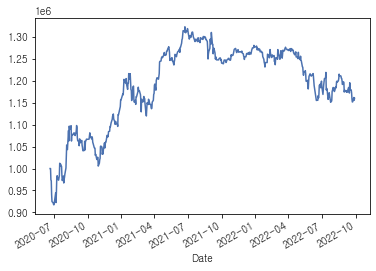

In [125]:
pf_positions.sum(axis = 1).plot()

In [209]:
snp_500 = snp_500.loc[snp_500.index.isin(pf_returns.index)]
kospi = kospi.loc[kospi.index.isin(pf_returns.index)]

* get bench

In [239]:
import seaborn as sns

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


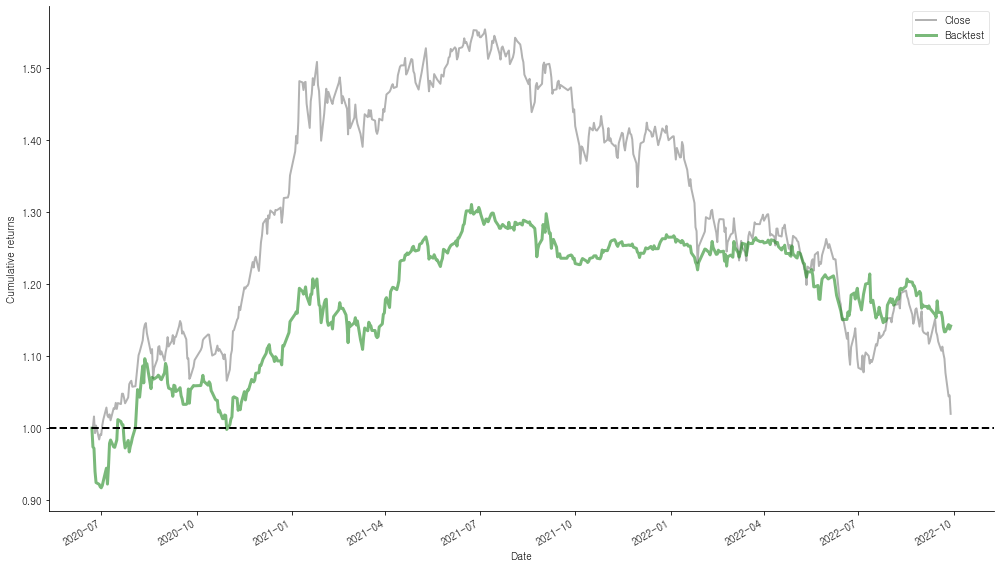

In [247]:
pf.plot_rolling_returns(returns=pf_returns.loc[pf_returns.index.isin(kospi.index)], 
                     factor_returns=kospi.pct_change(), 
                    #live_start_date=start_date,
                     cone_std=(1.0, 1.5, 2.0))
plt.gcf().set_size_inches(14, 8)
sns.despine()
plt.tight_layout()

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


<AxesSubplot:xlabel='Date', ylabel='Cumulative returns'>

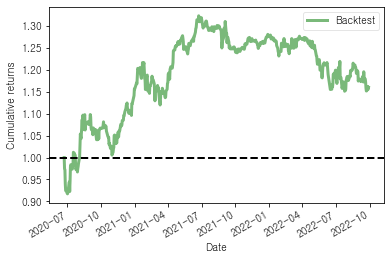

In [187]:
pf.plot_rolling_returns(pf_returns)

<AxesSubplot:xlabel='Date', ylabel='Returns'>

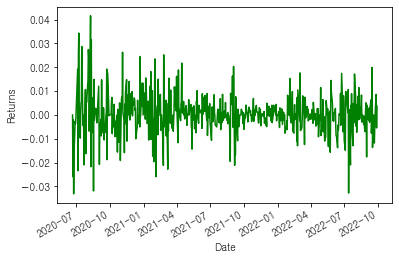

In [188]:
pf.plot_returns(pf_returns)

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

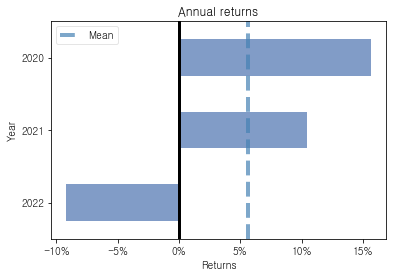

In [189]:
pf.plot_annual_returns(pf_returns)

<AxesSubplot:title={'center':'Distribution of monthly returns'}, xlabel='Returns', ylabel='Number of months'>

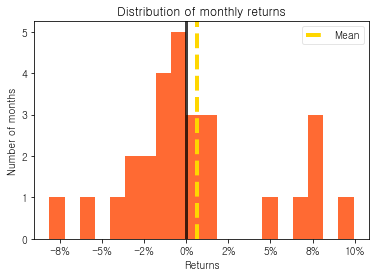

In [190]:
pf.plot_monthly_returns_dist(pf_returns)

<AxesSubplot:title={'center':'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

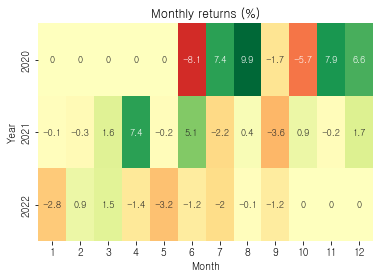

In [191]:
pf.plot_monthly_returns_heatmap(pf_returns)

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:xlabel='Date'>

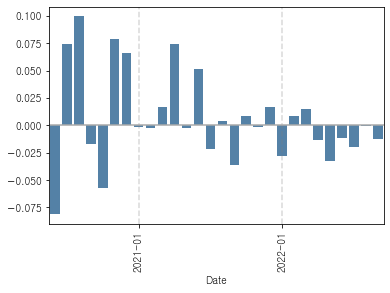

In [192]:
pf.plot_monthly_returns_timeseries(pf_returns)

<AxesSubplot:title={'center':'Return quantiles'}>

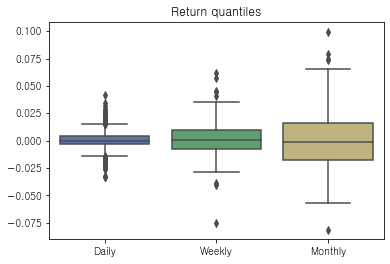

In [193]:
pf.plot_return_quantiles(pf_returns)

<AxesSubplot:>

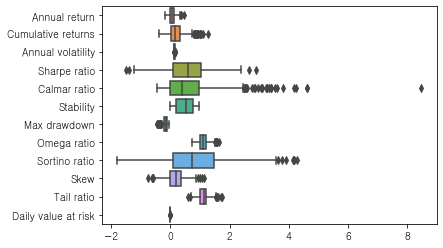

In [194]:
pf.plotting.plot_perf_stats(pf_returns, None)

In [195]:
pf.plotting.show_perf_stats(pf_returns)

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2020-06-22
End date,2022-09-28
Total months,28
,Backtest
Annual return,6.5%
Cumulative returns,16.0%
Annual volatility,13.5%
Sharpe ratio,0.54
Calmar ratio,0.50
Stability,0.39
Max drawdown,-13.0%


In [196]:
pf.plotting.show_worst_drawdown_periods(pf_returns, top = 3)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.99,2021-06-23,2022-07-25,NaT,NaN
1,8.41,2020-09-01,2020-10-30,2020-12-03,68
2,8.27,2020-06-22,2020-07-01,2020-07-17,20


C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)


<AxesSubplot:title={'center':'Rolling portfolio beta to Close'}, ylabel='Beta'>

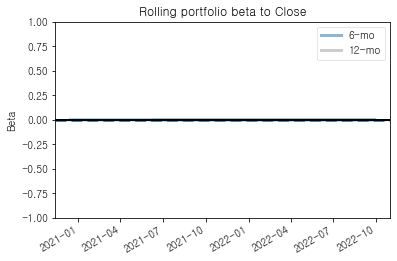

In [201]:
pf.plotting.plot_rolling_beta(pf_returns, kospi)

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

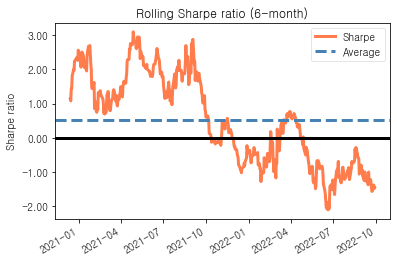

In [202]:
pf.plot_rolling_sharpe(pf_returns)

<AxesSubplot:title={'center':'Top 10 drawdown periods'}, ylabel='Cumulative returns'>

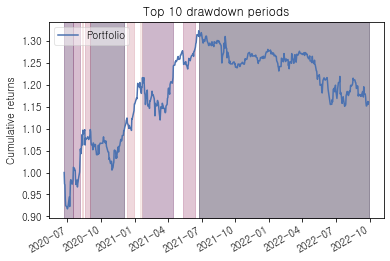

In [203]:
pf.plot_drawdown_periods(pf_returns)

<AxesSubplot:title={'center':'Underwater plot'}, ylabel='Drawdown'>

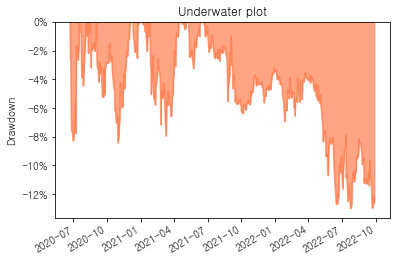

In [204]:
pf.plot_drawdown_underwater(pf_returns)

In [312]:
pf.timeseries.annual_return(pf_returns)

C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  """Entry point for launching an IPython kernel.


0.065301922448461

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2020-06-22
End date,2022-09-28
Total months,28
,Backtest
Annual return,6.5%
Cumulative returns,16.0%
Annual volatility,13.5%
Sharpe ratio,0.54
Calmar ratio,0.50
Stability,0.39
Max drawdown,-13.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.99,2021-06-23,2022-07-25,NaT,NaN
1,8.41,2020-09-01,2020-10-30,2020-12-03,68
2,8.27,2020-06-22,2020-07-01,2020-07-17,20
3,7.94,2021-01-21,2021-03-10,2021-04-15,61
4,4.44,2020-07-17,2020-07-28,2020-08-04,13


C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


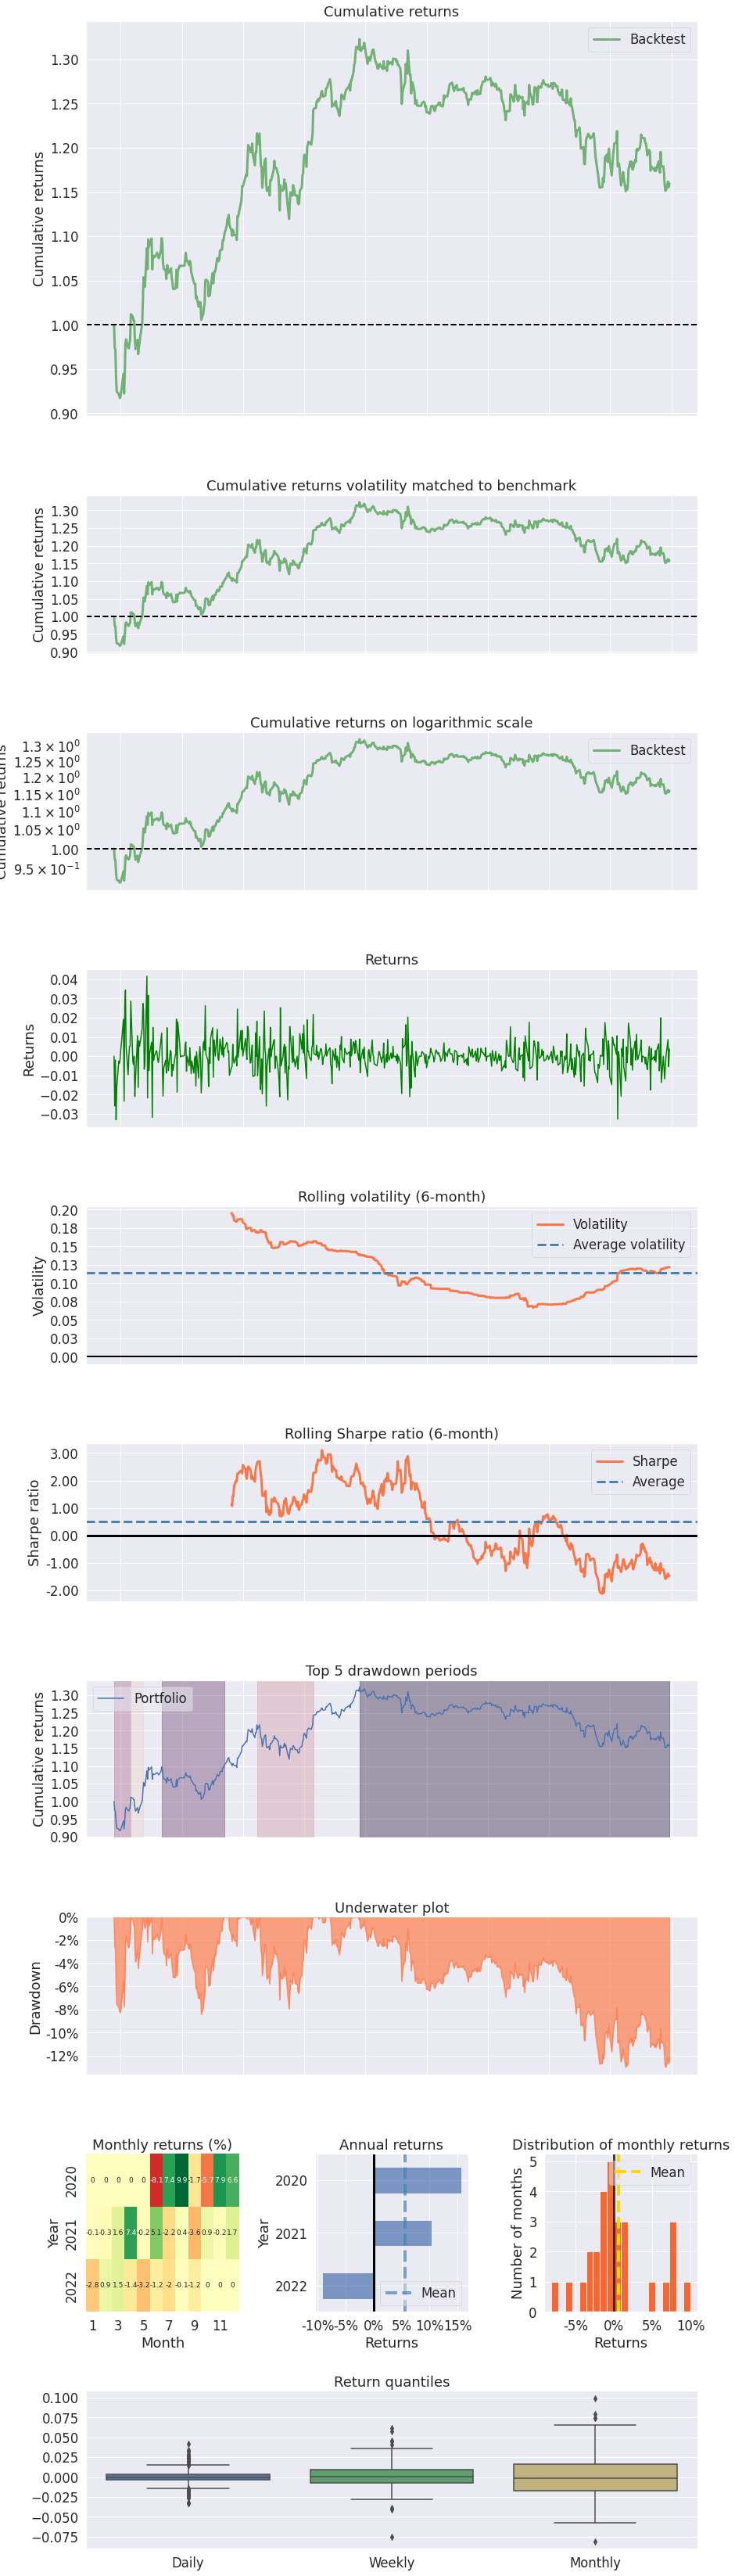

In [213]:
pf.create_returns_tear_sheet(pf_returns)

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2020-06-22
End date,2022-09-28
Total months,27
,Backtest
Annual return,8.5%
Cumulative returns,20.5%
Annual volatility,13.5%
Sharpe ratio,0.67
Calmar ratio,0.81
Stability,0.54
Max drawdown,-10.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.50,2021-07-13,2022-06-16,NaT,NaN
1,8.69,2021-01-21,2021-03-10,2021-04-15,61
2,8.39,2020-06-22,2020-07-07,2020-07-17,20
3,8.23,2020-09-01,2020-10-30,2020-12-03,68
4,4.44,2020-07-17,2020-07-28,2020-08-04,13


C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:54

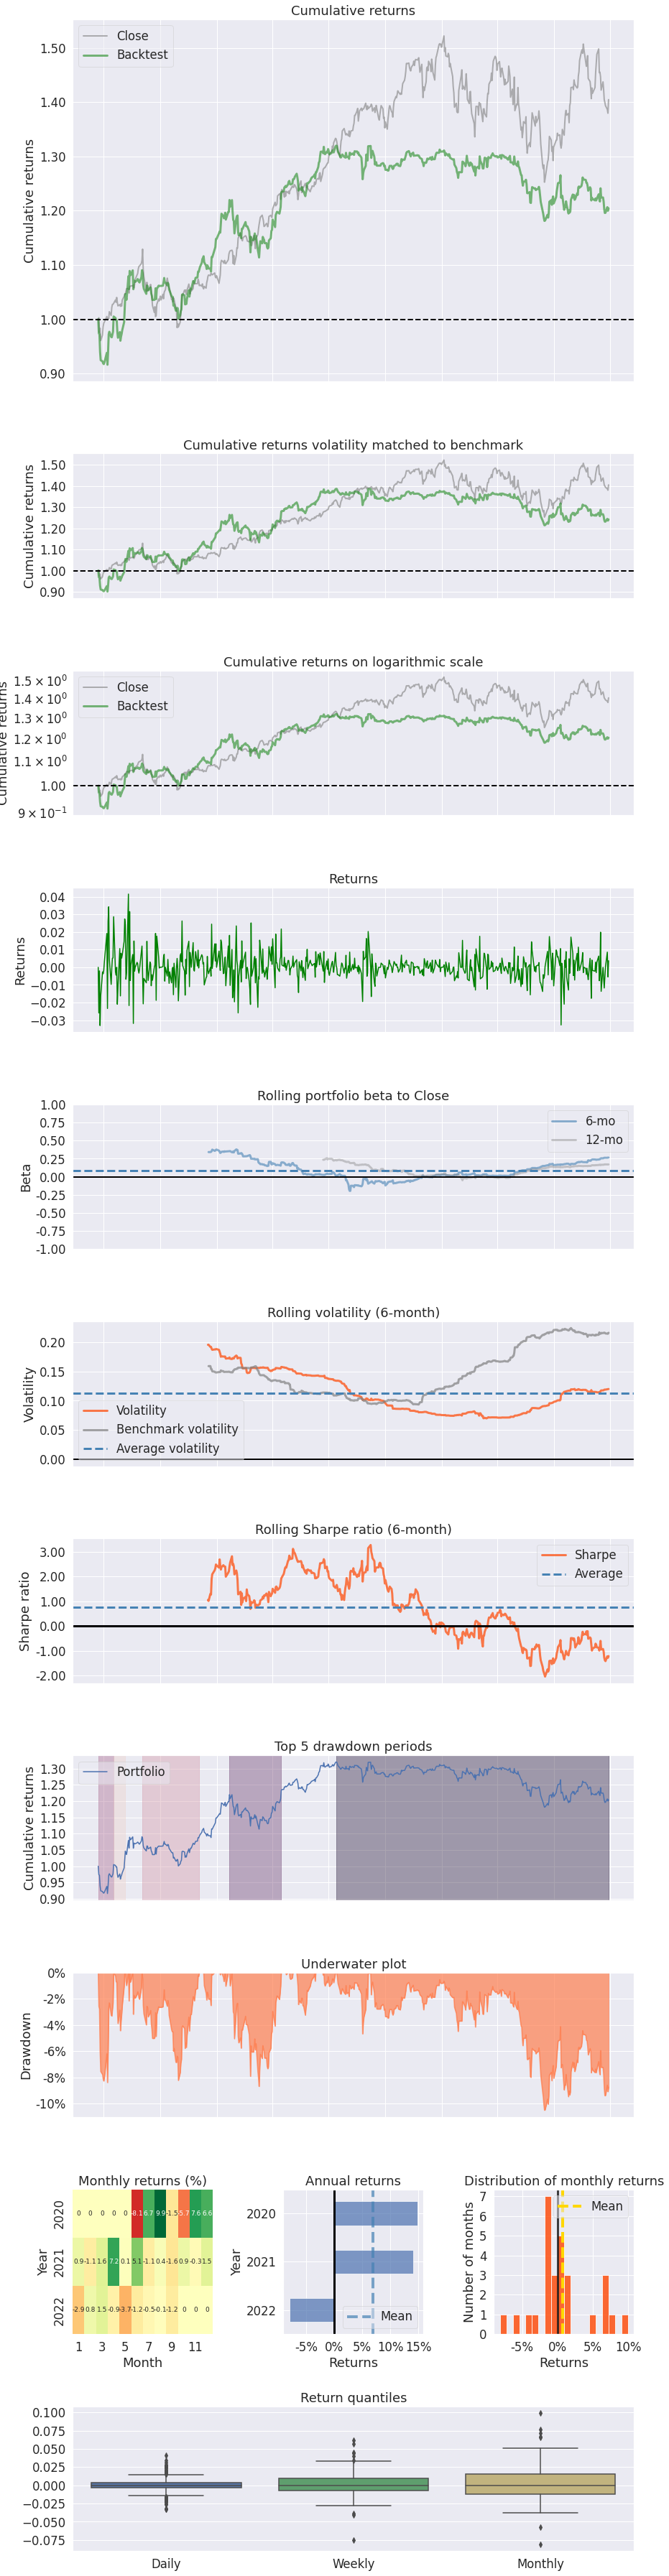

In [216]:
pf.create_returns_tear_sheet(pf_returns.loc[pf_returns.index.isin(snp_500.index)],
                             benchmark_rets=snp_500.pct_change())

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2020-06-22
End date,2022-09-28
Total months,26
,Backtest
Annual return,6.1%
Cumulative returns,14.2%
Annual volatility,14.0%
Sharpe ratio,0.51
Calmar ratio,0.45
Stability,0.40
Max drawdown,-13.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.50,2021-06-23,2022-09-22,NaT,NaN
1,8.97,2020-08-12,2020-10-30,2020-12-07,84
2,8.27,2020-06-22,2020-07-01,2020-07-17,20
3,8.12,2021-01-21,2021-03-10,2021-04-15,61
4,4.44,2020-07-17,2020-07-28,2020-08-04,13


C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:54

Stress Events,mean,min,max
New Normal,0.03%,-3.31%,4.16%


C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:1229: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


Top 10 long positions of all time,max
삼천리자전거,40.48%
LG전자,32.56%
KODEX 미국S&P500TR,31.63%
고려신용정보,26.17%
SK바이오사이언스,25.57%
애플,19.07%
OCI,18.25%
KODEX 코스피TR,16.99%
퀄컴,15.84%
카카오,14.27%


Top 10 short positions of all time,max


Top 10 positions of all time,max
삼천리자전거,40.48%
LG전자,32.56%
KODEX 미국S&P500TR,31.63%
고려신용정보,26.17%
SK바이오사이언스,25.57%
애플,19.07%
OCI,18.25%
KODEX 코스피TR,16.99%
퀄컴,15.84%
카카오,14.27%


C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:1470: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  avg_returns_given_slippage = pd.Series()


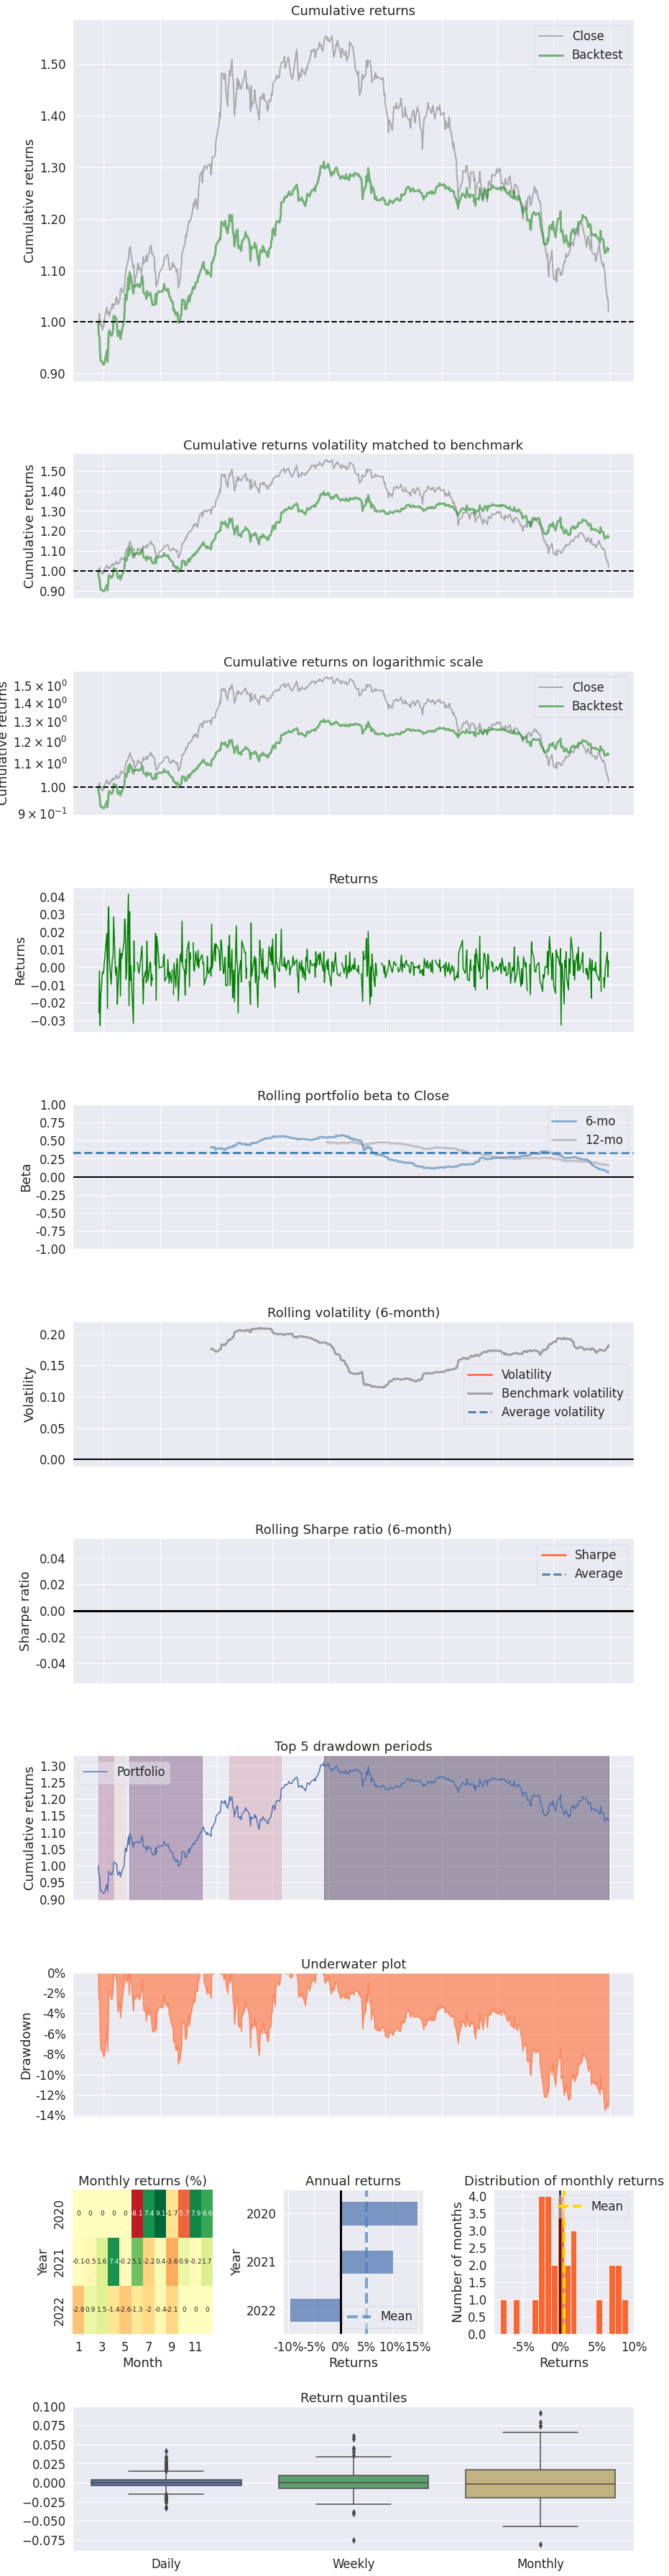

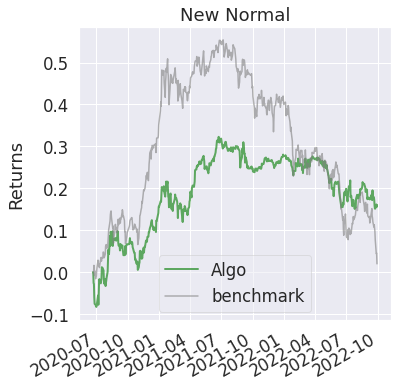

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-package

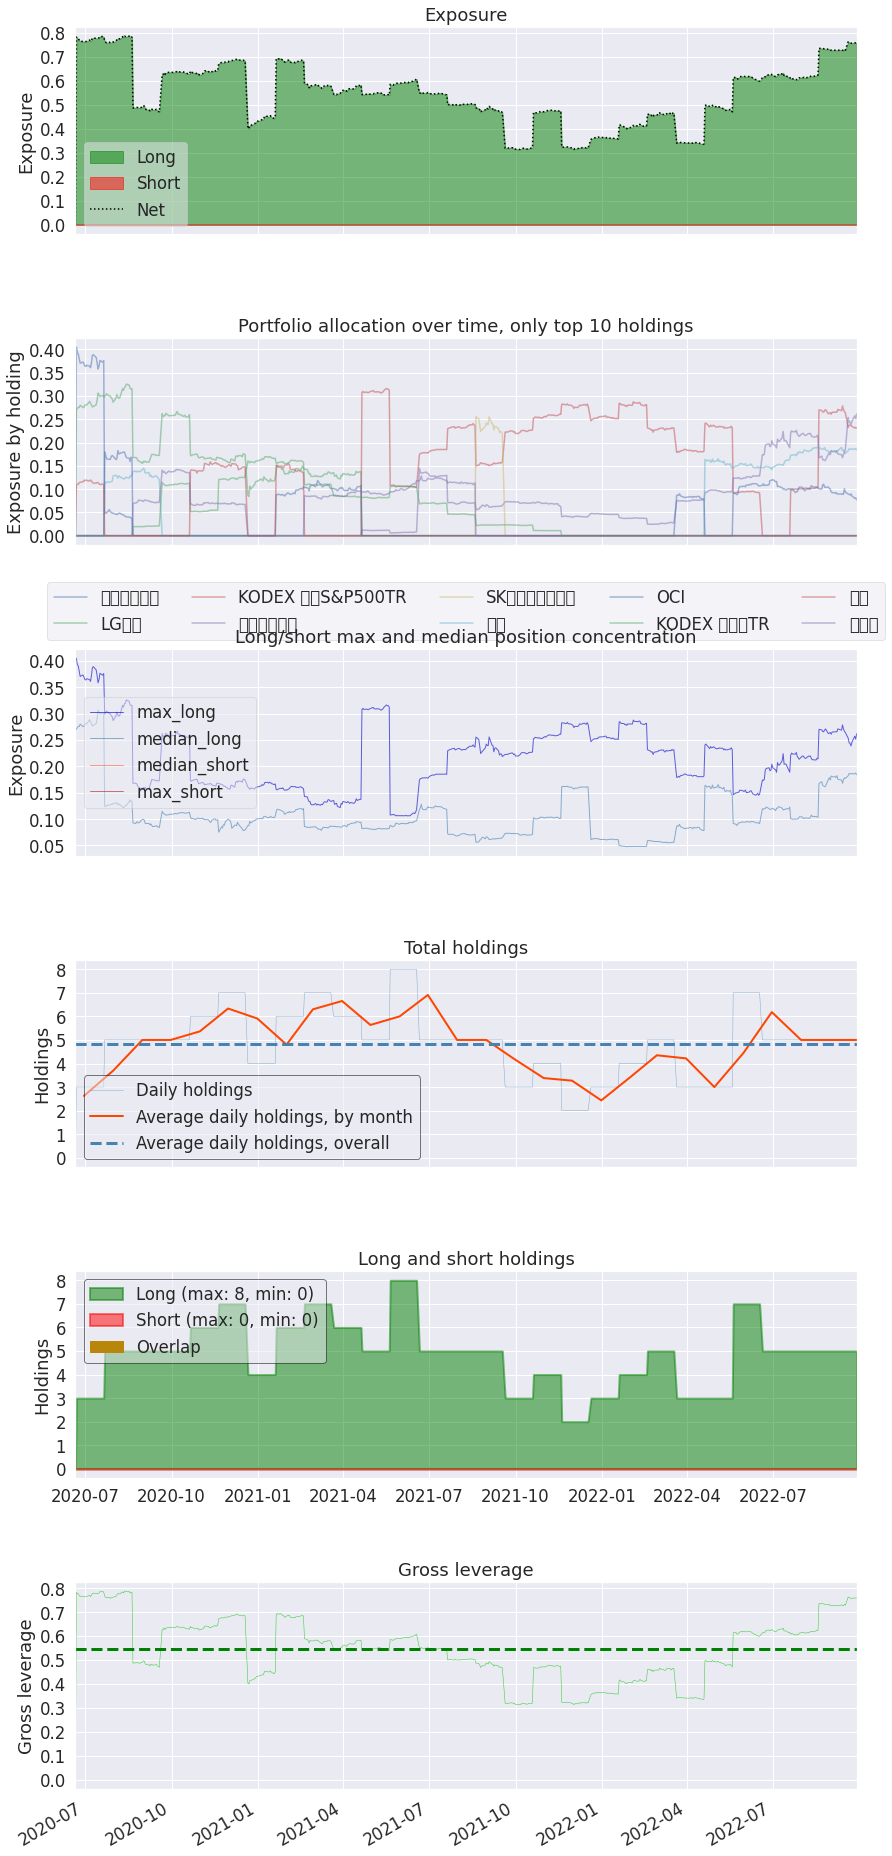

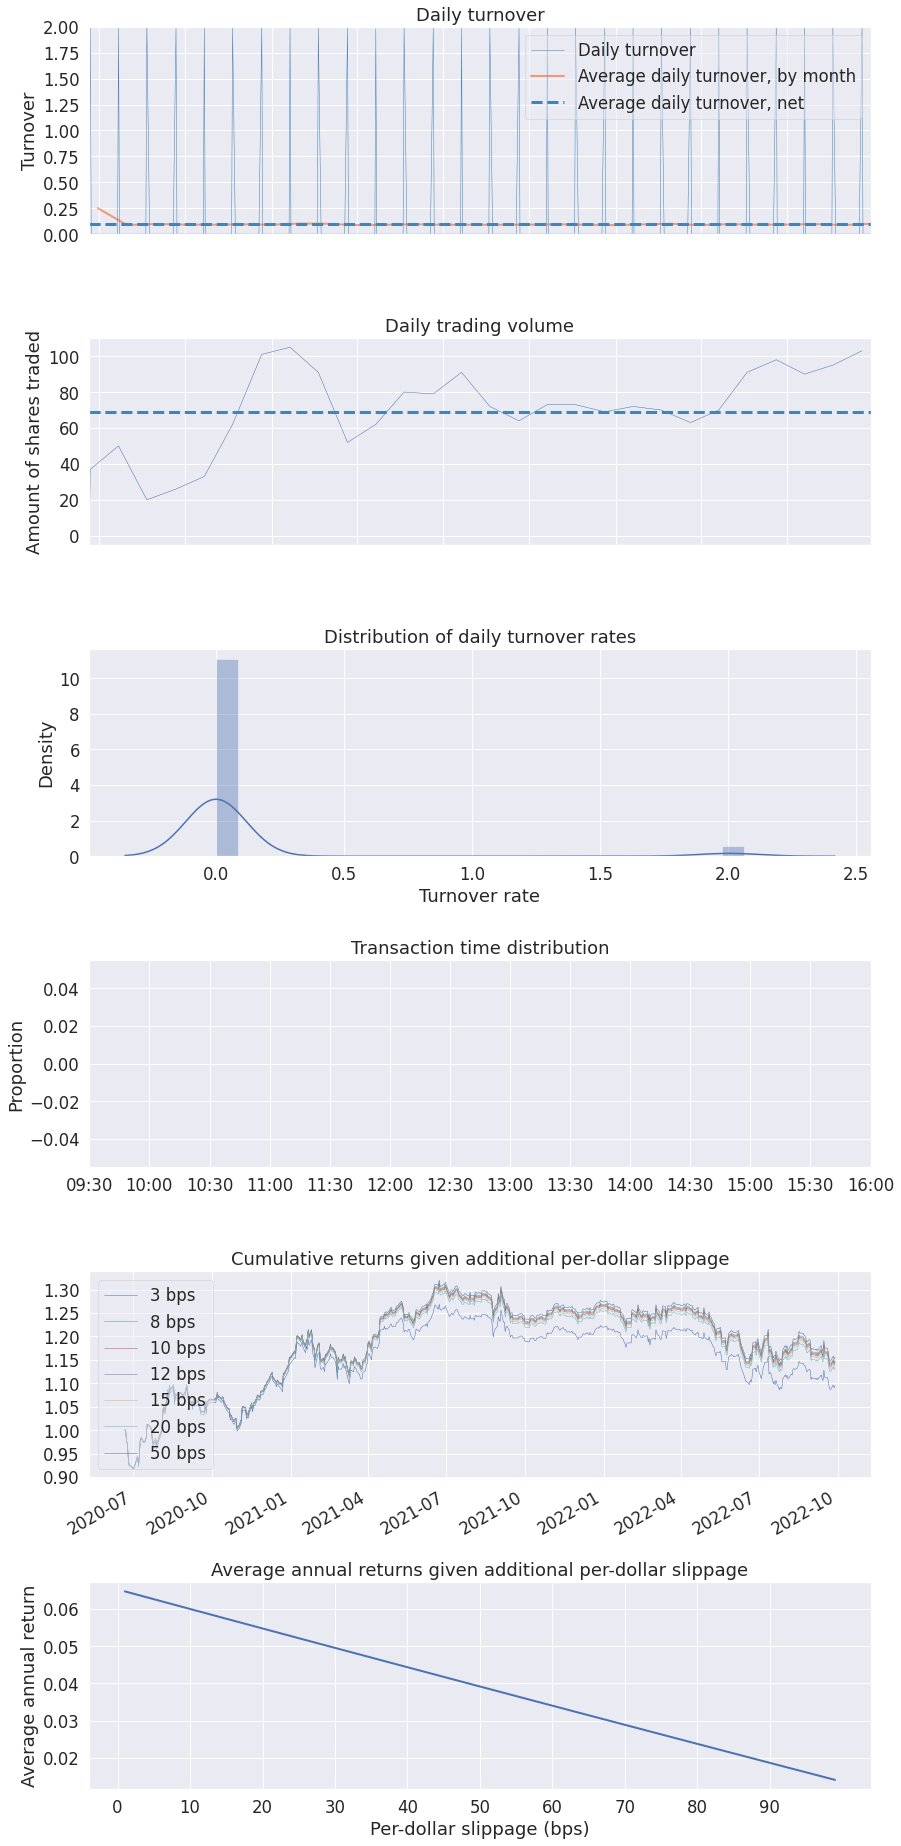

In [218]:
pf.create_full_tear_sheet(pf_returns,
                          positions=pf_positions,
                          transactions=pf_transactions,
                          benchmark_rets=kospi.pct_change(),
                          slippage=0.1)

In [19]:
print("The Sharpe Ratio of the backtest is: ", empyrical.sharpe_ratio(bt_returns))

The Sharpe Ratio of the backtest is:  1.543354454834436


In [20]:
print("The market beta of the backtest is: ", empyrical.beta(bt_returns,benchmark_rets))

The market beta of the backtest is:  0.5516223402218898


In [21]:
print("The maxmimum drawdown of the backtest is: ", empyrical.max_drawdown(bt_returns))

The maxmimum drawdown of the backtest is:  -0.04906836872744358


In [146]:
bt_returns.index

DatetimeIndex(['2013-01-02 00:00:00+00:00', '2013-01-03 00:00:00+00:00',
               '2013-01-04 00:00:00+00:00', '2013-01-07 00:00:00+00:00',
               '2013-01-08 00:00:00+00:00', '2013-01-09 00:00:00+00:00',
               '2013-01-10 00:00:00+00:00', '2013-01-11 00:00:00+00:00',
               '2013-01-14 00:00:00+00:00', '2013-01-15 00:00:00+00:00',
               ...
               '2013-12-17 00:00:00+00:00', '2013-12-18 00:00:00+00:00',
               '2013-12-19 00:00:00+00:00', '2013-12-20 00:00:00+00:00',
               '2013-12-23 00:00:00+00:00', '2013-12-24 00:00:00+00:00',
               '2013-12-26 00:00:00+00:00', '2013-12-27 00:00:00+00:00',
               '2013-12-30 00:00:00+00:00', '2013-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=252, freq=None)

In [147]:
benchmark_rets.index

DatetimeIndex(['2013-01-03 00:00:00+00:00', '2013-01-04 00:00:00+00:00',
               '2013-01-07 00:00:00+00:00', '2013-01-08 00:00:00+00:00',
               '2013-01-09 00:00:00+00:00', '2013-01-10 00:00:00+00:00',
               '2013-01-11 00:00:00+00:00', '2013-01-14 00:00:00+00:00',
               '2013-01-15 00:00:00+00:00', '2013-01-16 00:00:00+00:00',
               ...
               '2013-12-17 00:00:00+00:00', '2013-12-18 00:00:00+00:00',
               '2013-12-19 00:00:00+00:00', '2013-12-20 00:00:00+00:00',
               '2013-12-23 00:00:00+00:00', '2013-12-24 00:00:00+00:00',
               '2013-12-26 00:00:00+00:00', '2013-12-27 00:00:00+00:00',
               '2013-12-30 00:00:00+00:00', '2013-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=251, freq=None)

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


<AxesSubplot:xlabel='date', ylabel='Cumulative returns'>

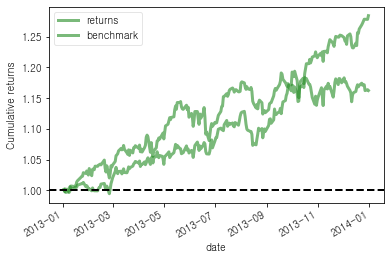

In [274]:
pf.plotting.plot_rolling_returns(pd.concat([bt_returns, benchmark_rets], axis = 1))

In [ ]:
# Cumulative Returns
plt.subplot(2,1,1)
pf.plotting.plot_rolling_returns(bt_returns[:-1], benchmark_rets)

In [ ]:
# Daily, Non-Cumulative Returns
plt.subplot(2,1,2)
pf.plotting.plot_returns(bt_returns)
plt.tight_layout()